In [118]:
import math
from typing import Any

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns
import glasbey

# Comparing LLM models to manual labels

In [119]:
df = pd.read_excel("Topic_Results.xlsx")
df

,Title,Abstract,Topic,MetaTopic,embedding_alpha,embedding_beta,Manual Labelling Cleaned
0,2023 5th International Conference on Environme...,The proceedings contain 118 papers. The topics...,Unlabelled,Unlabelled,4.346168,1.266299,"Ocean Chemistry Detection, Contaminated Ocean ..."
1,20th century cooling of the deep ocean contrib...,The historical evolution of Earth’s energy imb...,Biogeochemical Cycles,Unlabelled,2.826810,3.990208,Ocean Currents And Circulation
2,21 000 birds in 4.5 h: efficient large-scale s...,We address the task of automatically detecting...,Aerial Wildlife Surveys,Image Object Detection,8.058338,-0.504681,Species Distribution
3,A 10-year record of Arctic summer sea ice free...,Satellite observations of pan-Arctic sea ice t...,Arctic Sea Ice,Unlabelled,1.488173,5.255651,Ice Monitoring
4,A Bayesian Deep Learning Approach to Near-Term...,Since model bias and associated initialization...,Climate & Ocean Dynamics Modeling,Ocean Modeling & Forecasting,1.527949,2.390450,Climate Modelling
...,...,...,...,...,...,...,...
890,Wild salmon enumeration and monitoring using d...,Pacific salmon have experienced declining abun...,Underwater Image Analysis,Image Object Detection,7.642435,-0.301564,Biodiversity Monitoring
891,Winter Precipitation and Summer Temperature Pr...,Climate change can have strong effects on aqua...,Water Quality Modeling,Water Quality,4.700716,2.965399,Natural Disaster Forecasting
892,Year-round sea ice and snow characterization f...,Satellite microwave observations from 1.4 to 3...,Arctic Sea Ice,Unlabelled,1.539828,5.414557,Ice Monitoring
893,eWaSR—An Embedded-Compute-Ready Maritime Obsta...,Maritime obstacle detection is critical for sa...,Vessel Detection And Tracking,Unlabelled,5.639313,-1.154923,Shipping Navigation And Logistics


### Using exploded (i.e. duplicated) rows when there is more than one label

In [120]:
manual_df = df.copy()

# Cleanup categories
manual_df['Label'] = df['Manual Labelling Cleaned'].str.split(", ")
manual_df = manual_df.explode("Label", ignore_index=True).reset_index()
len(manual_df)

971

In [121]:
# Visualize the manual labels

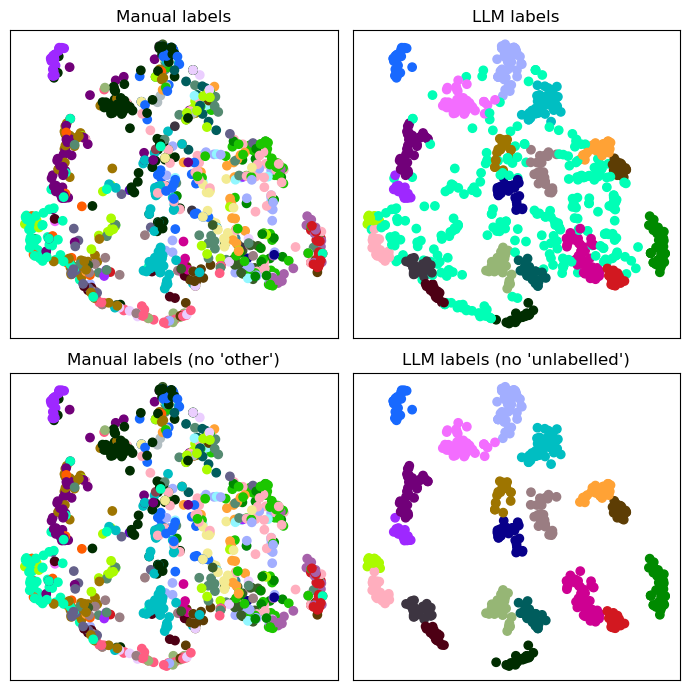

In [122]:
def plot_clusters(d: pd.DataFrame):
    plt.figure(figsize=(7,7))

    # MANUAL
    ax = plt.subplot(2,2,1)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    uniques, X = np.unique(d['Label'], return_inverse=True)
    p = glasbey.create_palette(palette_size=len(uniques))
    cmp = ListedColormap(p)
    plt.title("Manual labels")
    plt.scatter(d['embedding_alpha'], d['embedding_beta'], c=X, cmap=cmp)

    # Without "other"
    ax = plt.subplot(2,2,3)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    plt.title("Manual labels (no 'other')")
    plt.scatter(d[~(d['Label'] == "Other")]['embedding_alpha'], d[~(d['Label'] == "Other")]['embedding_beta'], c=X[~(d['Label'] == "Other")], cmap=cmp)

    # LLM
    ax = plt.subplot(2,2,2)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    uniques, X = np.unique(d['Topic'], return_inverse=True)
    p = glasbey.create_palette(palette_size=len(uniques))
    cmp = ListedColormap(p)
    plt.title("LLM labels")
    plt.scatter(d['embedding_alpha'], d['embedding_beta'], c=X, cmap=cmp)

    # Without "unlabelled"
    ax = plt.subplot(2,2,4)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    plt.title("LLM labels (no 'unlabelled')")
    plt.scatter(d[~(d['Topic'] == 'Unlabelled')]['embedding_alpha'], d[~(d['Topic'] == 'Unlabelled')]['embedding_beta'], c=X[~(d['Topic'] == 'Unlabelled')], cmap=cmp)
    
    plt.tight_layout()
    plt.show()


plot_clusters(manual_df)

The LLM labels will obviously match the embedding well, because they were derived from it. But, we should expect to see some cohesion with the manual labels as well. We do for certain clusters, but there are also areas where things are a bit more of a mess. I would guess that this might be caused somewhat by having a few labels in our original picklist that were a bit too broad.

Next, I wanted to see which LLM-derived best matched with the manual labels. To do this, I look at the pairwise Jaccard similarity between all the LLM and Manual labelled clusters. This tells us, more or less, how much overlap there is in the sets of papers in a manually-labelled cluster and a llm-labelled cluster.

In [123]:
def jaccard_similarity(a: set[Any], b: set[Any]):
    """a and b are sets of the Titles or ids for papers in a particular cluster"""
    intersect = len(a.intersection(b))
    union = len(a.union(b))
    return intersect / union

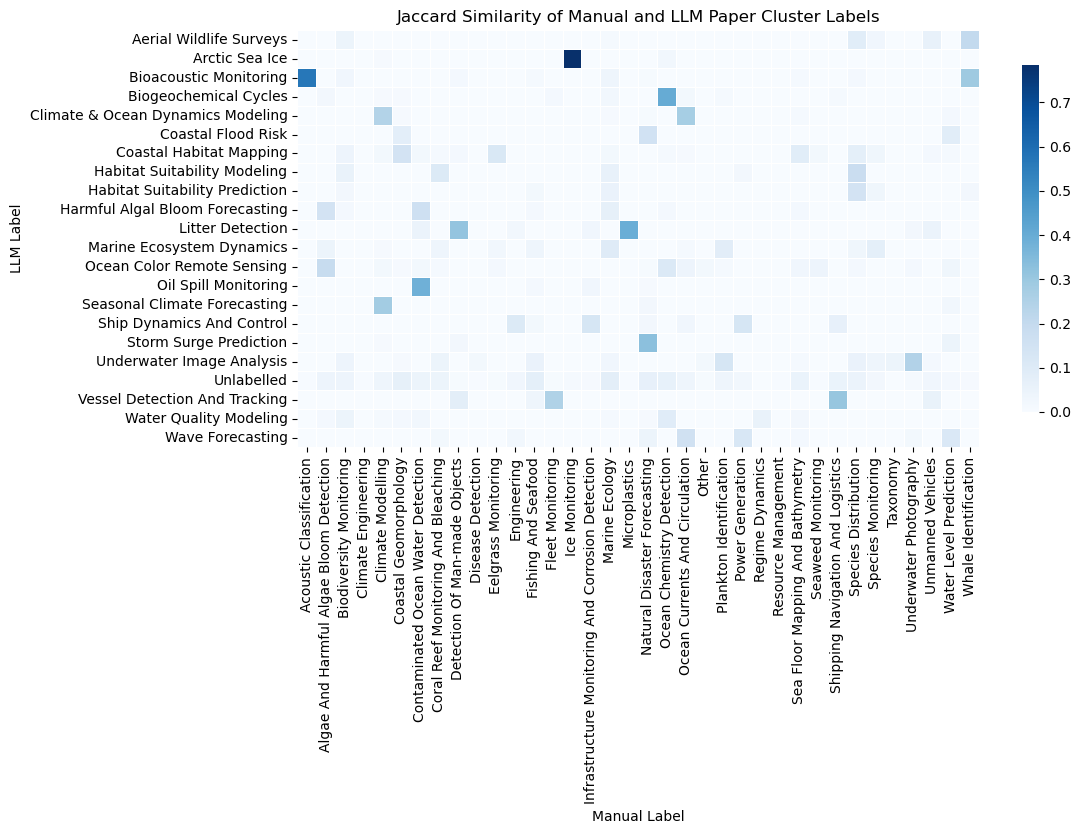

In [124]:
def plot_similarity_heatmap(d: pd.DataFrame):
    data = []
    for manual_label in d['Label'].unique():
        for llm_label in d['Topic'].unique():
            ms = set(d[d['Label'] == manual_label]['Title'])
            ls = set(d[d['Topic'] == llm_label]['Title'])
            similarity = jaccard_similarity(ms, ls)
    
            data.append({
                "Manual Label": manual_label,
                "LLM Label": llm_label,
                "Jaccard Similarity": similarity
            })
            
    data = pd.DataFrame(data)
    dp = data.pivot(columns='Manual Label', index='LLM Label', values='Jaccard Similarity') 
    
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))
    
    # Draw the heatmap with the mask and correct aspect ratio
    g = sns.heatmap(dp, cmap="Blues", linewidths=.5, cbar_kws={"shrink": .5}, annot=False, fmt=".1f")
    g.set(title="Jaccard Similarity of Manual and LLM Paper Cluster Labels", aspect="equal")
    plt.show()


plot_similarity_heatmap(manual_df)

### Same analysis as above, using first label in the manual labels list

In [125]:
manual_df = df.copy()

# Cleanup categories
manual_df['Label'] = df['Manual Labelling Cleaned'].str.split(", ").str[0]
len(manual_df)

895

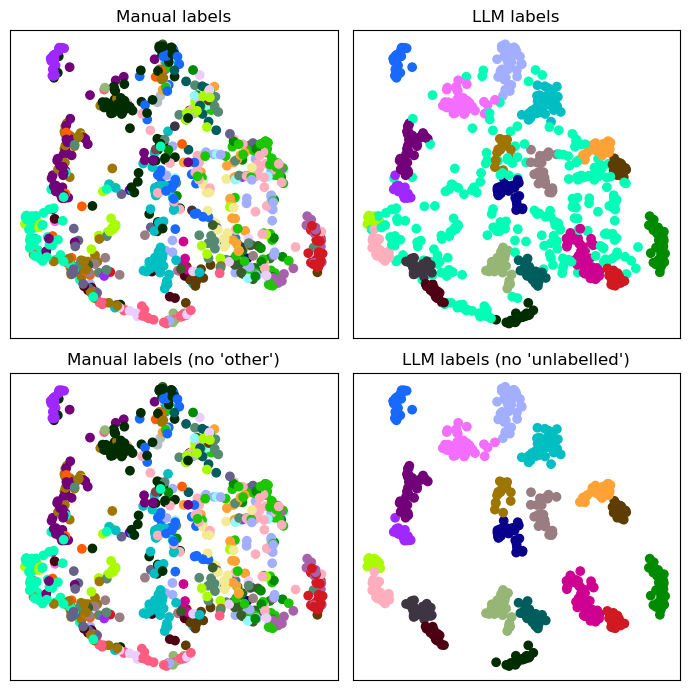

In [126]:
plot_clusters(manual_df)


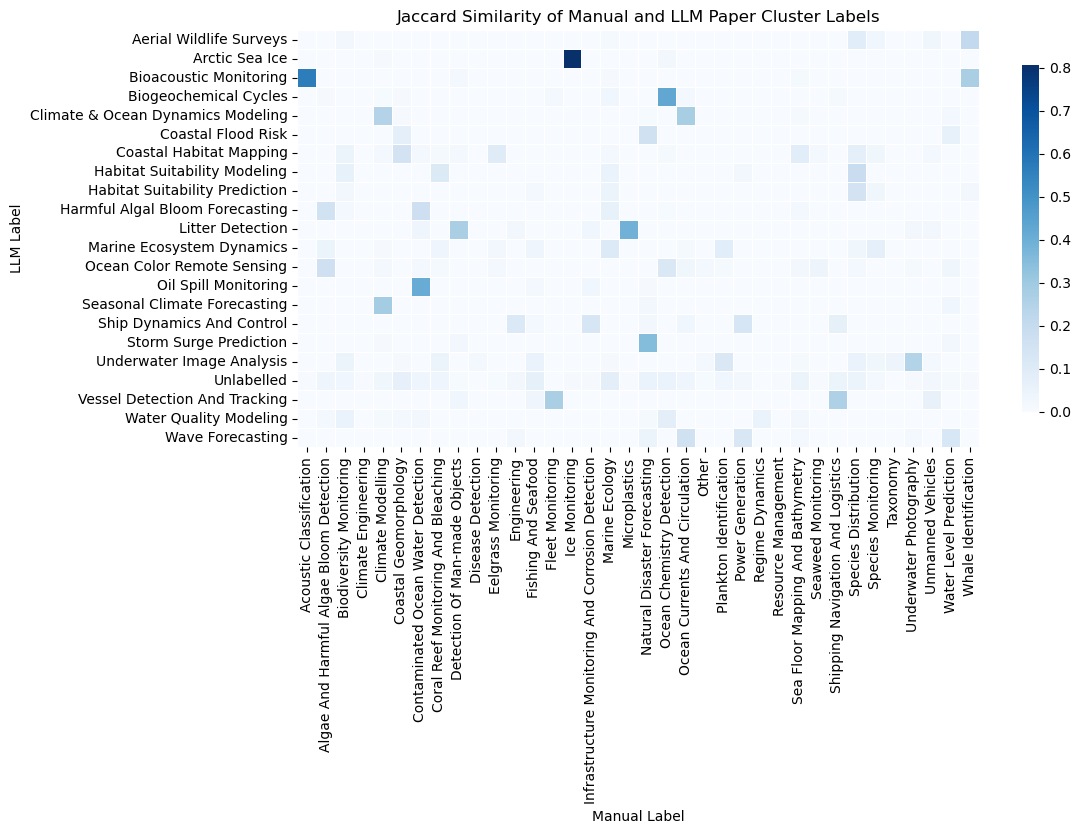

In [127]:
plot_similarity_heatmap(manual_df)

Things look basically the same, no matter how we handle papers with multiple labels. So, going forward I'm just going to use the first label since it's simpler to handle

### Removing rarely used labels

In [129]:
for manual_label in manual_df['Label'].unique():
    sub_df = manual_df[manual_df['Label'] == manual_label]
    print(f"count: {str(len(sub_df)):2} - {manual_label:40s} ")

count: 86 - Ocean Chemistry Detection                
count: 51 - Ocean Currents And Circulation           
count: 67 - Species Distribution                     
count: 32 - Ice Monitoring                           
count: 56 - Climate Modelling                        
count: 58 - Contaminated Ocean Water Detection       
count: 22 - Biodiversity Monitoring                  
count: 7  - Fleet Monitoring                         
count: 27 - Whale Identification                     
count: 15 - Detection Of Man-made Objects            
count: 14 - Species Monitoring                       
count: 51 - Marine Ecology                           
count: 27 - Sea Floor Mapping And Bathymetry         
count: 20 - Plankton Identification                  
count: 13 - Unmanned Vehicles                        
count: 30 - Fishing And Seafood                      
count: 27 - Shipping Navigation And Logistics        
count: 26 - Acoustic Classification                  
count: 38 - Coastal Geomorph

I'm going to use the same cluster threshold that I used for deriving the LLM labels. That is, any cluster that doesn't have at least 17 papers in it will be considered as topic "other"

In [136]:
for manual_label in manual_df['Label'].unique():
    sub_df = manual_df[manual_df['Label'] == manual_label]
    count = len(sub_df)
    if count < 17:
        # Reassign when necessary
        manual_df.loc[manual_df['Label'] == manual_label, 'Label'] = "Other"

for manual_label in manual_df['Label'].unique():
    sub_df = manual_df[manual_df['Label'] == manual_label]
    print(f"count: {str(len(sub_df)):2} - {manual_label:40s} ")

count: 86 - Ocean Chemistry Detection                
count: 51 - Ocean Currents And Circulation           
count: 67 - Species Distribution                     
count: 32 - Ice Monitoring                           
count: 56 - Climate Modelling                        
count: 58 - Contaminated Ocean Water Detection       
count: 22 - Biodiversity Monitoring                  
count: 119 - Other                                    
count: 27 - Whale Identification                     
count: 51 - Marine Ecology                           
count: 27 - Sea Floor Mapping And Bathymetry         
count: 20 - Plankton Identification                  
count: 30 - Fishing And Seafood                      
count: 27 - Shipping Navigation And Logistics        
count: 26 - Acoustic Classification                  
count: 38 - Coastal Geomorphology                    
count: 62 - Natural Disaster Forecasting             
count: 23 - Coral Reef Monitoring And Bleaching      
count: 19 - Underwater Phot

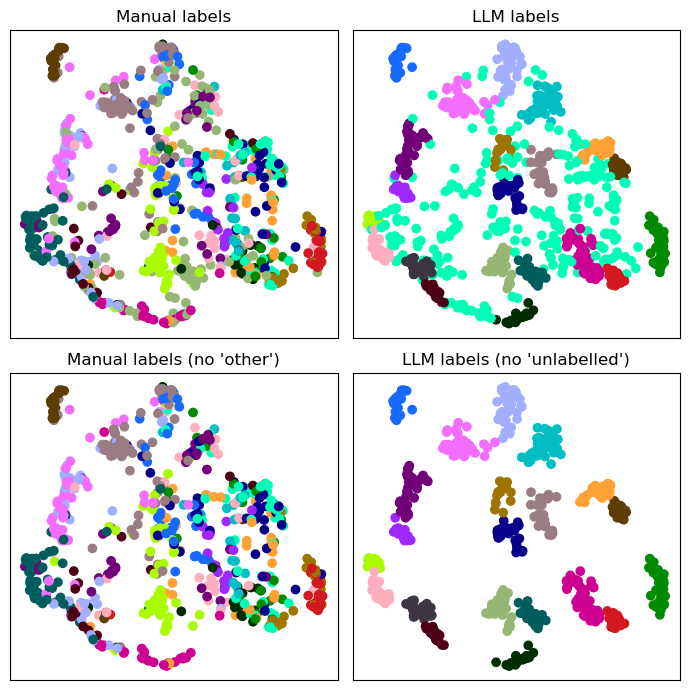

In [137]:
plot_clusters(manual_df)

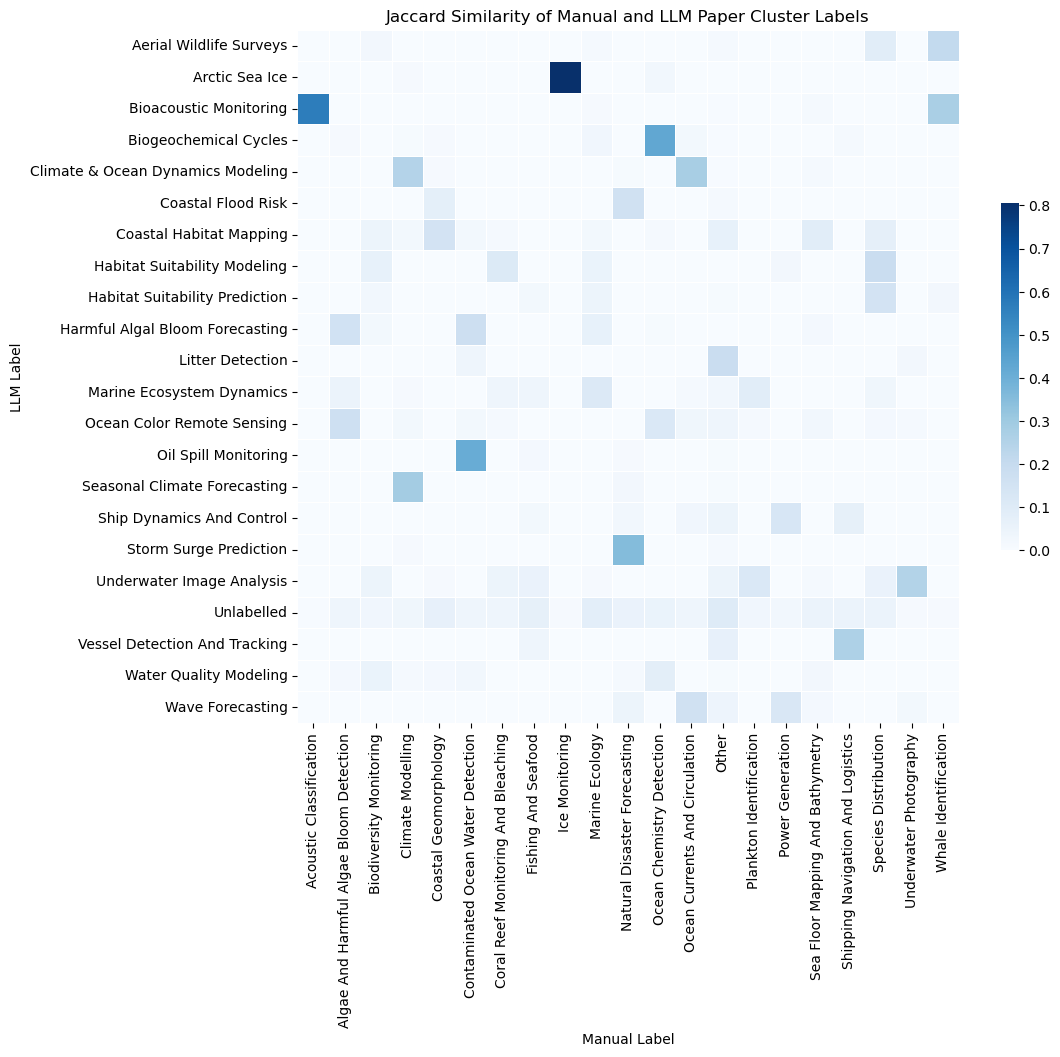

In [138]:
plot_similarity_heatmap(manual_df)

The manual labels are not wildly improved, so I'd suggest that we go forward using the LLM derived labels

# Cluster Cohesion Analysis

I'm curious about the variance of each cluster, between the LLM labels and the manual labels. We can also calculate cluster centers and find what might be representative papers for each group. I'm going to just do this using the first manual label if there are multiple for simplicity.

## LLM clusters

In [142]:
data = []

for llm_topic in manual_df['Topic'].unique():
    # Get the subset of papers
    d = manual_df[manual_df['Topic'] == llm_topic].copy()

    alpha_mean = d['embedding_alpha'].mean()
    beta_mean = d['embedding_beta'].mean()

    # Overall variance
    alpha_var = d['embedding_alpha'].var()
    beta_var = d['embedding_beta'].var()
    cov = d[["embedding_alpha", "embedding_beta"]].cov().loc['embedding_alpha', 'embedding_beta']
    overall_var = alpha_var + beta_var + 2*cov

    d['distance_to_mean'] = d.apply(lambda r: math.sqrt((r['embedding_alpha'] - alpha_mean) **2 + (r['embedding_beta'] - beta_mean)**2), axis=1)

    d.sort_values('distance_to_mean', inplace=True)

    data.append({
        "Topic": llm_topic,
        "Paper Variance": overall_var,
        "Rep. Paper 1": d.iloc[0]['Title'],
        "Rep. Paper 2": d.iloc[1]['Title'],
        "Rep. Paper 3": d.iloc[2]['Title'],
    })
    
    print(llm_topic)
    print(f"\tTopic Variance: {overall_var}")
    print(f"\tTop 3 Representative Papers:")
    for i in range(3):
        print(f"\t\t{i+1}: {d.iloc[i]['Title']}")
    print()

pd.DataFrame(data).to_excel("TopicPapers.xlsx")

Unlabelled
	Topic Variance: 7.730630885116763
	Top 3 Representative Papers:
		1: Experimental and modeling assessment of large-scale cultivation of microalgae Nannochloropsis sp. PTCC 6016 to reach high efficiency lipid extraction
		2: Predicting and improving the microbial removal of organic micropollutants during wastewater treatment: A review
		3: Versatile in silico modeling of partition coefficients of organic compounds in polydimethylsiloxane using linear and nonlinear methods

Biogeochemical Cycles
	Topic Variance: 0.15043441897463314
	Top 3 Representative Papers:
		1: Neural network-based estimates of Southern Ocean net community production from in situ <br>O2/Ar and satellite observation: A methodological study
		2: Global Estimates of Marine Gross Primary Production Based on Machine Learning Upscaling of Field Observations
		3: Global Contrasts Between Oceanic Cycling of Cadmium and Phosphate

Aerial Wildlife Surveys
	Topic Variance: 0.025715787308968015
	Top 3 Representative

## Manual labels

In [140]:
for manual_topic in manual_df['Label'].unique():
    # Get the subset of papers
    d = manual_df[manual_df['Label'] == manual_topic].copy()

    alpha_mean = d['embedding_alpha'].mean()
    beta_mean = d['embedding_beta'].mean()

    # Overall variance
    if len(d) > 1:
        alpha_var = d['embedding_alpha'].var()
        beta_var = d['embedding_beta'].var()
        cov = d[["embedding_alpha", "embedding_beta"]].cov().loc['embedding_alpha', 'embedding_beta']
        overall_var = alpha_var + beta_var + 2*cov
    else:
        overall_var = 0
        
    d['distance_to_mean'] = d.apply(lambda r: math.sqrt((r['embedding_alpha'] - alpha_mean) **2 + (r['embedding_beta'] - beta_mean)**2), axis=1)

    d.sort_values('distance_to_mean', inplace=True)
    
    print(manual_topic)
    print(f"\tTopic Variance: {overall_var}")
    print(f"\tTop 3 Representative Papers:")
    for i in range(min(3, len(d))):
        print(f"\t\t{i+1}: {d.iloc[i]['Title']}")
    print()

Ocean Chemistry Detection
	Topic Variance: 2.138627987933389
	Top 3 Representative Papers:
		1: A coastal N2 fixation hotspot at the Cape Hatteras front: Elucidating spatial heterogeneity in diazotroph activity via supervised machine learning
		2: Identifying and assessing matrix effect severity in inductively coupled plasma optical emission spectrometry using non-analyte signals and unsupervised learning
		3: Machine Learning Estimates of Global Marine Nitrogen Fixation

Ocean Currents And Circulation
	Topic Variance: 4.71040585376457
	Top 3 Representative Papers:
		1: A spatio-temporal LSTM model to forecast across multiple temporal and spatial scales
		2: Prediction of marine pycnocline based on kernel support vector machine and convex optimization technology
		3: Analyzing El Niño–Southern Oscillation Predictability Using Long-Short-Term-Memory Models

Species Distribution
	Topic Variance: 2.2084815669305584
	Top 3 Representative Papers:
		1: Rapid Genetic Identification of the Blu

# Export summary spreadsheet